# **뉴스기사 요약**
---
![이](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp08/data/news.png?raw=true)

이번 프로젝트에서는 뉴스의 내용을 학습해 주요내용(Headline)을 요약하는 모델을 구현해보겠다.
뉴스 기사 데이터(news_summary_more.csv)는 인도의 뉴스 사이트인 Inshorts.com에서 스크래핑된 데이터셋이다. 
 - [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

인도 뉴스이기때문에 인도식영어 문장이 있을수도 있으므로 테스트시 영국식영어 문장으로 구성된 텍스트를 위주로 분석을 진행해보겠다.


---

뉴스 기사 요약은 아래의 두가지 방법으로 진행하겠다.
1. 추상적 요약(Abstractive Summarization) 
 - seq2seq(sequence to sequence) 모델 이용
 - text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습을 진행

2. 추출적 요약(Extractive Summarization)
 - Summa의 summarize() 함수 활용
 - 오직 text열만을 사용하면 관련내용을 간단하게 요약해준다.


---



In [1]:
#TPU설정
import os
import tensorflow as tf

resolver=tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.33.135.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.135.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# 라이브러리

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 데이터 수집하기

뉴스 기사 데이터(news_summary_more.csv)를 다운로드해보자.

*  read_csv encoding
 - encoding 기본값 :  UTF when reading/writing (ex. ‘utf-8’)
 - encoding='iso-8859-1': Western Europe(latin_1 )

In [241]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.shape

(98401, 2)

In [7]:
data.tail()

,headlines,text
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


In [8]:
data['text'][1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [9]:
data['headlines'][1]

'Delhi techie wins free food from Swiggy for one year on CRED'

데이터셋에는 9만8천여건의 샘플데이터가 있으며, 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어있다. text 열의 내용을 요약한 것이 headlines 열이라고 할 수 있다. 

seq2seq모델을 통해  text 시퀀스를 입력받아 headlines의 시퀀스를 예측하도록 학습을 진행할 것인데, 모델에 입력하기전 text 시퀀스를 전처리 해주자.


#1. 추상적 요약(Abstractive Summarization)

## 1-1. 텍스트 데이터 전처리하기
    1. 중복 샘플 제거
    2. 결측치 샘플 제거
    3. 텍스트 정규화
    4. 불용어(stopwords) 제거
    5. 문장의 최대 길이 정하기
    6. 시작 토큰과 종료 토큰 추가하기
    7. 훈련 데이터와 테스트 데이터를 분리
    8. 단어사전(vocabulary) 만들기 및 정수 인코딩
    9. 빈문장이 있는지 다시한번 더 확인
    10. 문장의 길이 맞추기 (pad_sequences)



### 1-1-1. 중복 샘플 제거

In [242]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


headlines의 경우 요약 데이터이므로 중복값이 존재할수 있지만 뉴스 내용에  해당하는 text 데이터는 중복이되면 안되므로 중복샘플인 제거해야한다.

In [243]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 1-1-2. 결측치 샘플 제거
데이터에 Null 값이 남아있는지 알아보고 있다면 해당 샘플도 함께 제거해야한다.

In [244]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

 남아있는 98360 샘플중 결측치가 있는것은 없다.

### 1-1-3. 텍스트 정규화
98360 샘플의 문장에 단어들에 대해 정규화를 해주어야한다. 단어가 똑같은 의미를 가지고 있는 경우 다른 단어로 처리되지 않도록 해주는 작업이다.
텍스트 정규화를 위한 사전(dictionary)은 아래 사이트를 참고하여 구성하였다.

- [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [13]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}



### 1-1-4. 불용어(stopwords) 제거

이제 불용어를 제거해주어야한다. 불용어는 텍스트에는 자주 등장하지만 문맥적으로 중요한 의미를 담고있지 않다. 자연어 처리시 중요단어로 인식이 되지 않도록 제거해주어야한다. NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

- NLTK(Natural Language Toolkit) 
 - 영어 기호, 통계, 자연어 처리를 위한 라이브러리
 - 불용어 사전 : I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어를 미리 정의하고 있다.

In [14]:
print('불용어 개수 :', len(stopwords.words('english') )) # NLTK가 정의한 영어 불용어 리스트를 리턴
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

위에 정의된 정규화 사전과 불용어사전을 이용해 텍스트 전처리를 할 함수를 구현해보겠다. 이 함수에서는 text, headlines 문장을 입력받아 소문자로 만들고 뉴스에 포함된 html태그및 특수문자도 함께 제거한 후 최종적으로 문장의 토큰을 반환한다.

단 headlines문장의 경우 문장 요약의 결과로 표시될때 불용어가 제거되면 부자연스럽기 때문에 불용어 제거 없이 토크나이징만 진행할 것이다.

In [245]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [246]:
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:3])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']


In [247]:
# 전체 clean_headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:3])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak']


preprocess_sentence 함수로 삭제된 단어가 많을 것이므로 빈문장이 있지 않은지 확인해보아야한다. 

In [248]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [249]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

빈값을 가지는 샘플이 확인되지 않았다. 

### 1-1-5. 문장의 최대 길이 정하기
학습을 진행하기 위해서는 학습에 사용할 문장의 최대 길이를 결정하고, 문장의 시작과 끝을 표시하는 토큰을 문장에 추가해주겠다.

데이터셋 내에 존재하는 문장 길이에 대한 분포를 시각해보자.

text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


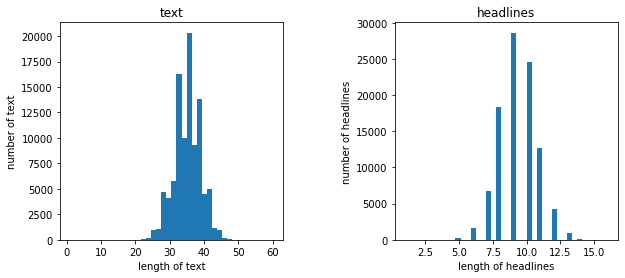

In [250]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(summary_len)))
print('headlines의 최대 길이 : {}'.format(np.max(summary_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.figure(1, figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.hist(text_len, bins = 40)
plt.xlabel('length of text')
plt.ylabel('number of text')
plt.title('text')

plt.subplot(1,2,2)
plt.hist(summary_len, bins = 40)
plt.xlabel('length of headlines')
plt.ylabel('number of headlines')
plt.title('headlines')
plt.show()


text와 headlines 데이터 모두 한쪽으로 치우침 없이 정규분포를 이루고 있다. 
headlines의 경우 최대, 최소길이의 차이도 크지않지만 text 길이가 45이상인 경우의 샘플과 headlines길이가 12이상인 샘플이 드물게 나타나고있다. 임의로 최대 길이 설정하여 어느정도 샘플이 삭제되는지 알아보자.



In [251]:
text_max_len = 50
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


99% 정도의 데이터가 존재하므로 이대로 최대길이를 설정해도 될것 같다.

In [253]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


### 1-1-6. 시작 토큰과 종료 토큰 추가하기

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해주어야한다.
- 토큰
 - 시작 토큰은 sostoken
 - 종료 토큰은 eostoken 

- headlins 데이터에 시작, 종료 토큰을 붙여 생성할 디코더 데이터
 - decoder_input 열 : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장
 - decoder_target 열 : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장


In [254]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해준다.

In [255]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 1-1-7. 훈련 데이터와 테스트 데이터를 분리
train_test_split함수로 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해주었다.

In [256]:
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test = train_test_split(encoder_input, test_size=0.2, random_state=121 )
decoder_input_train, decoder_input_test = train_test_split(decoder_input, test_size=0.2,  random_state=121 )
decoder_target_train, decoder_target_test = train_test_split(decoder_target, test_size=0.2, random_state=121 )

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77735
훈련 레이블의 개수 : 77735
테스트 데이터의 개수 : 19434
테스트 레이블의 개수 : 19434


### 1-1-8. 단어사전(vocabulary) 만들기 및 정수 인코딩

학습을 위해 정제한 텍스트데이터를 숫자로 바꾸는 작업을 해주겠다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하기 위해 단어 사전을 만들고 해당 사전과 관련하여 인코딩 작업을 해주면된다.

우선, Keras의 토크나이저를 사용하여 원문에 해당되는 encoder_input_train에 대해서 단어 사전을 만들어주겠다.

In [257]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

fit_on_texts함수 호출시 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 생성되었다. 이 단어집합(src_tokenizer.word_index)에서 사용빈도가 낮은 단어들은 훈련 데이터에서 제외할 것이다.

등장 빈도수가 9회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보고 비중이 작으면 관련 단어를 삭제해도 무방할것 같다.
- src_tokenizer.word_counts.items() : 단어와 각 단어의 등장 빈도수

In [258]:
def word_counts(src_tokenizer, threshold):
    total_cnt = len(src_tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in src_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

word_counts(src_tokenizer, 9)

단어 집합(vocabulary)의 크기 : 69234
등장 빈도가 8번 이하인 희귀 단어의 수: 49884
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19350
단어 집합에서 희귀 단어의 비율: 72.05130427246729
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.259271744483268


encoder_input_train에는 69000여 개의 단어가 있다. 등장 빈도가 threshold 값인 9회 미만, 즉 8회 이하인 단어들은 단어 집합에서 72%정도 차지하고 있지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.25%밖에 되지 않는다.

그래서 등장 빈도가 8회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하겠다. 그리고 위에서 이를 제외한 단어 집합의 크기를 19000여개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 19,000으로 제한해서 단어사전을 다시 만들겠다. 

In [259]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
print(encoder_input_train[:3])

['japanese tabloid magazine spa apologised published list ranking women universities easy convince students sex drinking parties woman launched online campaign seeking apology suspension sales offensive issue would like apologise using sensational language appeal readers magazine said'
 'class female student hacked death assailant outside school madhya pradesh anuppur district police said friday assailant used sword severe neck girl walking school appear examination police detained man earlier accused eve teasing victim'
 'former reserve bank india chief raghuram rajan thursday said never resigned post step term ended talking demonetisation rajan said still entire data talk demonetisation date fixed demonetisation']


texts_to_sequences 적용 : 텍스트를 시퀀스로 인코딩


In [260]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3, 13, 65, 9254, 5056, 23, 160, 1815, 12, 822, 1910, 3018, 3893, 6936, 1678, 163, 14733, 27, 176, 65, 3777, 832, 95, 85, 1096, 4636, 784, 98, 2173, 3608, 954, 6936], [8494, 36, 56, 45, 13296, 3707, 1881, 58, 72, 380, 1264, 1250, 805, 60, 3019, 909, 7756, 15953, 4438, 1891, 1523, 1196, 8, 376, 1881, 4, 17383, 759, 684, 10, 12508, 801, 1239], [11, 1092, 323, 4752, 3894, 28, 51, 3437, 1316, 2353, 12186, 13297, 2588, 3685, 3437, 813, 1392, 5135, 6662, 650, 9255, 6662, 89, 515, 2205, 1543, 714, 2159, 687, 11471, 5136, 6662, 612, 983, 1649, 813, 13297, 399, 2515, 983, 1649, 813, 10426]]


headlines 데이터에 대해서도 동일한 작업을 진행해주겠다. 단 headlines 데이터의 경우 text보다 문장이 짧기 때문에 희귀단어의 임계치를 7로 조정했다.

In [261]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

word_counts(tar_tokenizer, 7)

단어 집합(vocabulary)의 크기 : 29989
등장 빈도가 6번 이하인 희귀 단어의 수: 20507
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9482
단어 집합에서 희귀 단어의 비율: 68.38173997132282
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.3745010772089685


decoder_input_train에는 3만여 개의 단어가 있다. 등장 빈도가 6회 이하인 단어들은 단어 집합에서 68% 이상을 차지하고 있고 등장 빈도로 차지하는 비중은 5.3%로 확인된다. 이 단어를 제외한 단어집합의 크기는 9482개으로 9000건정도로 설정하면 될 것 같다.

In [262]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:3])
print('decoder ',decoder_target_train[:3])

input  [[1, 39, 4653, 174, 10, 100, 125, 1249, 4, 28], [1, 696, 3542, 1250, 19, 336, 4822, 108], [1, 2511, 3747, 50, 1391, 165, 1699, 4823, 2146]]
decoder  [[39, 4653, 174, 10, 100, 125, 1249, 4, 28, 2], [696, 3542, 1250, 19, 336, 4822, 108, 2], [2511, 3747, 50, 1391, 165, 1699, 4823, 2146, 2]]


### 1-1-9. 빈문장이 있는지 다시한번 더 확인
인코더, 디코더 데이터는 이제 빈도수가 높은 단어의 인덱스로 구성되어있다. 그런데 빈도수가 낮은 단어가 있는 샘플은 빈 샘플로 남아 있을 것이므로 해당 샘플도 제거해주어야한다. 

디코더 데이터의 경우 토큰을 하나씩 추가했으므로 문자길이가 1인경우 빈샘플로 볼수 있다.

In [263]:
drop_train = [index for index, sentence in enumerate(encoder_input_train) if len(sentence) == 0]
drop_test = [index for index, sentence in enumerate(encoder_input_train) if len(sentence) == 0]
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


인코더 데이터의경우 빈샘플이 없다. 디코더 데이터를 살펴보자

In [264]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


In [265]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77734
훈련 레이블의 개수 : 77734
테스트 데이터의 개수 : 19434
테스트 레이블의 개수 : 19434


디코더 데이터의 경우 빈샘플이 하나발견되어 삭제해주었다. 빈샘플이 별로 없는 것은대부분의 문장이 빈도수가 많은 단어들로 구성되었기때문인것 같다.

### 1-1-10. 문장의 길이 맞추기 (pad_sequences)

이제 정수로 인코딩된 샘플의 서로 다른 길이를 같은 길이로 맞춰주는 패딩 작업을 해주겠다. 미리 정해둔 최대 길이를 설정하고 패딩은 훈련시 효과가 좋은 앞공간에 넣어주도록 할것이다.

In [266]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 1-2. 모델 설계하기

### 1-2-1. 기본 seq2seq 모델 설계하기

<img src="https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG" width="600" height="200"/>


seq2seq는 크게 인코더와 디코더라는 두 개의 모듈로 구성된다.
- 인코더 
 - 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 컨텍스트 벡터(context vector)로 만든다.
 - 인코더의  hidden state와 cell state를 디코더에 넘겨준다.

- 디코더 
 - Language Model(언어모델) : 문장(시퀀스)에 확률을 부여하는 모델이다.
 - 컨텍스트 벡터는 디코더셀의 첫번째 은닉 상태에 사용된다.
 - 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력한다.


 

### 1-2-2. 어텐션 메커니즘 사용하여 모델 개선하기

기본적인 seq2seq모델의 디코더 출력층을 바꿔서 성능을 높일수 있다. 이를 위해 어텐션 메커니즘을 활용해보겠다.

<img src="https://www.researchgate.net/profile/Chandan-Reddy-2/publication/329464533/figure/fig3/AS:701043021197314@1544153089772/An-attention-based-seq2seq-model.ppm" width="600" height="400"/>


- **어텐션 메커니즘 (Attention Mechanism)**
 - 하나의 고정된 크기의 벡터에 모든 정보를 압축하여 정보 손실이 발생하는 seq2seq 모델의 단점을 보완
 - 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다.
 - **attention : 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중해서 본다.**




---
TPU사용을 위해 한 함수내에 인코더, 디코더모델을 함께 구현해보겠다.

하이퍼 파라미터
- embedding_dim = 128 : 임베딩벡터의 차원
- hidden_size = 256 : LSTM 뉴런의 갯수

인코더 구조
- Embedding 레이어
 - 18000개 단어로 이루어진 text 데이터에 임베딩(문장 최대길이:40)
- LSTM 레이어 
 - return_sequences : 앞쪽 순환층의 모든 은닉상태를 출력하기위해 설정
 - return_state : 마지막 시점의 은닉 상태 출력
 - dropout : 은닉층에 있는 셀의 입력에 dropout 적용
 - recurrent_dropout : 순환되는 은닉상태에 대해 dropout 적용, 즉, dropout을 레이어가 아닌 time step마다 해주는 방식. 기술적문제로 GPU로 훈련시키지 못하는 점이 있다.

디코더 구조 - 기본적인 seq2seq 모델
- Embedding 레이어
 - 9000개 단어로 이루어진 headlines 데이터에 임베딩(문장 최대길이:12)
- LSTM 레이어 
 - initial_state : 컨텍스트 벡터인 인코더의 hidden state와 cell state의 값 설정
- Dense 레이어(디코더 출력층)
 -  headlines 9000개 단어중 text데이터를 요약하는데 필요한 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어하므로 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.

**디코더 구조중 출력층 바꾸기** - 어텐션 메커니즘의 활용
 - [Bahdanau 스타일의 어텐션](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)
 - 표준 seq2seq 모델은 인코더 마지막 hidden state만 디코더의 컨텍스트 벡터로 사용되기 때문에 일반적으로 긴 입력 시퀀스를 정확하게 처리하기 어렵다.
 - 어텐션 메커니즘은 디코딩 처리시 입력시퀀스의 모든 hidden state를 활용하여 특정 요소를 선택하여 출력을 생성한다.
 - attn_layer : 어텐션 함수의 입력으로 인코더의 hidden state들과 디코더의 hidden state를 사용
 - 어텐션 함수가 리턴한 값과 디코더의 hidden state를 함께 활용하여 요약문을 구성할 단어를 예측한다.





- LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
 - return_sequences : 앞쪽 순환층의 모든 은닉상태를 출력하기위해 설정
 - return_state : 마지막 시점의 은닉 상태 출력
 - dropout : 은닉층에 있는 셀의 입력에 dropout 적용
 - recurrent_dropout : 순환되는 은닉상태에 대해 dropout 적용, 기술적문제로 GPU로 훈련시키지 못하는 점이 있다. 

In [267]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

def createModel():
    embedding_dim = 128
    hidden_size = 256

    #------------------------------------------- 인코더
    encoder_inputs = Input(shape=(text_max_len,))

    # 인코더의 임베딩 층
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


    #------------------------------------------- 디코더 
    decoder_inputs = Input(shape=(None,))

    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # 디코더의 출력층
    '''
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

    # 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model.summary()
    '''
    #-------------------------------------------  디코더의 출력층 개선 - 어텐션 적용
    # 어텐션 층(어텐션 함수)
    attn_layer = AdditiveAttention(name='attention_layer')

    # 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    # 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model.summary()

    return model

## 1-3. 모델 훈련

**EarlyStopping**
- 조기 종료, 훈련진행시 특정 조건이 충족되면 훈련을 멈추는 역할
 > es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
- monitor(관찰대상) : 위 코드에서는 val_loss(검증 데이터의 손실)
- patience : 종료 조건, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측

In [268]:
with strategy.scope():
    model = createModel()
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')  
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
            validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
            batch_size=256, callbacks=[es], epochs=50)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 50, 128)      2432000     ['input_37[0][0]']               
                                                                                                  
 lstm_60 (LSTM)                 [(None, 50, 256),    394240      ['embedding_30[0][0]']           
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                           

val_loss가 3.5063에서 더이상 줄어들지않아 epoch 32번째에서 멈추었다. 조기종료로 그 이후로 과적합을 막아주었다.
훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는지 시각화를 통해 확인해보자. 

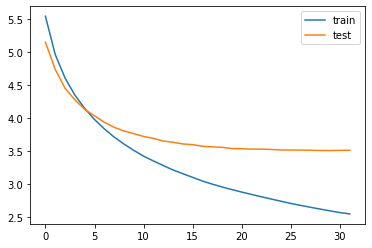

In [269]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 1-4. 인퍼런스 모델 설계하기

모델의 훈련이 끝났으므로 테스트를 진행해보겠다. 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비한다.

In [270]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

**인퍼런스?**
- 인퍼런스(Inference, 추론)란 학습을 마친 모델로 실제 새로운 입력 데이터에 적용하여 결과를 내놓는 과정을 말한다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdspFH4%2FbtrfpsIYHs2%2FekOoKY0DhGloYhriaGrkfK%2Fimg.png" width="600" height="300"/>

따라서 seq2seq 모델은 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다. 하지만 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이 만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [271]:
def createInferenceModel():
    embedding_dim = 128
    hidden_size = 256

    #------------------------------------------- 인코더
    encoder_inputs = Input(shape=(text_max_len,))
    # 인코더의 임베딩 층
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

    # added for Inference
    encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

    # 이전 시점의 상태들을 저장하는 텐서
    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))

    #------------------------------------------- 디코더 
    decoder_inputs = Input(shape=(None,))

    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb2 = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM

    # 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
    # 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.    
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

    #-------------------------------------------  디코더의 출력층 - 어텐션 적용
    # 어텐션 층(어텐션 함수)
    decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
    attn_layer = AdditiveAttention(name='attention_layer')
    attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

    # 최종 디코더 모델
    decoder_model = Model(
        [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs2] + [state_h2, state_c2])

    return encoder_model, decoder_model

encoder_model, decoder_model = createInferenceModel()

### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [272]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 1-5. 모델 테스트
정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인할수있도록 함수를 만들어주겠다. 
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
- headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [273]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


## 1-6. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열) 추상적 요약의 결과를 비교해보자.

In [274]:
for i in range(110, 115):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rapper badshah appearance koffee karan revealed two women time made revelation game segment take shots guilty something badshah revealed dated nine women far 
실제 요약 : have been with two women at the same time reveals 
예측 요약 :  strapped northeast introduced bush produces development judgement subway iits slept slept


원문 : talking former employee sexual harassment allegations director vikas bahl filmmaker bahl partner phantom films anurag kashyap said believe completely bahl done anurag added whatever happened wrong handle well failed cannot blame anyone said support 
실제 요약 : what vikas bahl has done is anurag on harassment row 
예측 요약 :  sharing strapped northeast introduced bush produces nations farooq farooq newborns newborns


원문 : official trailer shabana azmi starrer hollywood film black prince unveiled ongoing cannes film festival film based maharaja duleep singh last king sikh empire also starring film release english hindi punjabi july 
실제 요약 : trailer of shabana azmi holly

결과적으로 요약이 잘된 것 같진 않다. 이전 LMS에서 진행했던 아마존 리뷰 요약보다 val_loss값이 1.84 였는데 그보다 손실값이 2배나 높게 나왔다.

> sharing strapped northeast introduced bush produces nations farooq farooq newborns newborns

요약 내용중에 farooq, newborns와 같은 단어가 반복되기도 하고 원문의 키워드도 요약내용중에 거의 보이지 않는다. 더 많은 개선이 필요한것 같다.

---
# 2. 추출적 요약(Extractive Summarization)

- [summa packages](https://summanlp.github.io/textrank/)

In [135]:
!pip install summa

     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=a07ded1d34a0e1dddb9fa30ff07a5a2b86525fb95c35a6a1bc8658075ac15f23
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [174]:
import requests
from summa.summarizer import summarize

## 2-1. Summa을 이용해서 추출적 요약해보기

Summa 패키지
- 추출적 요약을 위한 모듈인 summarize를 제공
- 본문에 존재하는 단어구, 문장을 뽑아서 요약

summarize 함수
- 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 따라서 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 

파라미터 
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
 - ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [222]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

summarize 함수는 내부적으로 토큰화를 수행하므로 원문을 넣어주기위해 다시 data를 로드하였다. 

In [229]:
summarize(data2['text'][1],  ratio=0.4)

'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.'

추출적요약을위해 ratio를 설정해주었는데 원문이 짧아서 ratio를 0.3이하로 설정시 요약결과가 나오지않아 원본에서 선택되는 문장비율을 0.4정도로 잡아주었다. 

In [275]:
for i in range(100, 105):
    print("원문 :", data2['text'][i])
    print("실제 요약 :", data2['headlines'][i])
    print("예측 요약 :", summarize(data2['text'][i],  ratio=0.4))
    print("\n")

원문 : German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.
실제 요약 : Bosch makes its 1st India investment in IISc spinoff SimYog
예측 요약 : 


원문 : Mumbai-headquartered talent technology startup Shortlist has raised $2 million in a Series A round of funding. The round was led by Blue Haven Initiative, with participation from Compass Venture Capital, Zephyr Acorn among others. Founded by Simon Desjardins, Paul Breloff and Matt Schnuck, Shortlist screens candidates using predictive chat-based interviews and online competency-based assessments.
실제 요약 : Mumbai's talent tech startup Shortlist raises $2 million
예측 요약 : Mumbai-headquartered talent technolo

추출적 요약의 경우 실제 요약과 예측요약이 엇비슷한 경우가 많은것 같다. 
단 헤드라인으로 쓰기에 제목이 좀 길어서 좀더 축약적인 표현을 쓰지 못하는 부분이 아쉽다. 

 - 실제 요약 : Mumbai's talent tech startup Shortlist raises \$2 million
 - 예측 요약 : Mumbai-headquartered talent technology startup Shortlist has raised $2 million in a Series A round of funding.



# 3. 추상적 요약과 추출적 요약 비교
추출적요약을 잘활용하면 좀더 유연한 문장을 만들수 있을것 같지만 아직 내가 만든 모델의 한계가 있어 추출적 요약 비교할때 문법완성도면이나 키워드 포함면에서 많은 부분이 부족했다.

 - 핵심단어 포함 결과 비교 : 추출적 요약은 기존문장에서 문장을 꺼내 왔기때문에 핵심단어를 많이 포함하고 있다. 하지만 기존문장을 간단히 요약할수 있는 다른 단어를 만드는 데에는 한계가 있어보인다.
 
 - 문법완성도 결과 비교 : 추출적 요약이 역시 원문을 가져왔으므로 문법도 그대로 적용되어 읽을때 어색함이 없다. 추상적 요약은 같은 단어가 문장에 반복되는 경우가 많고,  문법에 어긋난 표현도 자주 나타난다. 




---
# 정리.

- 이번 프로젝트에서는 처음으로 자연어 처리를 위한 모델 두개를 연결하여 진행해보았다. 입력으로 들어오는 원문과 출력으로 나오는 요약문의 결과 길이가 다르고 출력단에서 반영해야하는 부분이 원문과 원문을 요약한 데이터이기 때문에 인코더, 디코더 모델을 따로 설계하여 쓰는 것을 알게되었다.
 >model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

- 테스트를 위해 인퍼런스 모델을 따로 만들어 테스트를 진행했는데, 아직은 기존 모델과 차이점을 이해하기 어려웠지만 현업에서 많이 쓰이는 부분이라 앞으로 더 익숙해져야할 것 같다.

- TPU의 활용 : LSTM에서 recurrent_dropout를 True로 설정할 경우 GPU를 사용하지못하게 되었다. 대신 일구님의 도움으로 코랩에서 지원하는 TPU를 사용해 보았는데 3배 이상 빠르게 모델을 학습시킬수 있어 많은 도움이 되었다. 





---
# Reference
- [Sequence-to-Sequence](https://wikidocs.net/24996)
- https://ichi.pro/ko/cheoeumbuteo-chusangjeog-in-tegseuteu-yoyag-ihae-205262993770163
